In [ ]:
%autosave 1

Autosaving every 1 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
data_dir = '/content/drive/MyDrive/Thermal Map Image Dataset/split datasett'
data_dir = pathlib.Path(data_dir)
train_dir = '/content/drive/MyDrive/Thermal Map Image Dataset/split dataset/train'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/Thermal Map Image Dataset/split dataset/test'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/Thermal Map Image Dataset/split dataset/val'
valid_dir = pathlib.Path(valid_dir)

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 1858 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 834 files belonging to 2 classes.


In [ ]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode = "categorical",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=1, shuffle = False)

Found 872 files belonging to 2 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['Healthy', 'Sick']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

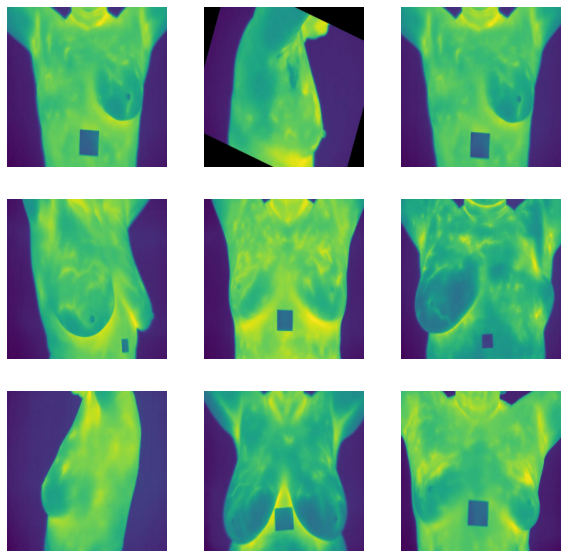

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    #pooling="max",
    #classifier_activation="softmax",
)

473186304/473176280 [==============================] - 2s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [ ]:
prediction_layer = tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
# x = global_average_layer(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 117,749,410
Trainable params: 2,562
Non-trainable params: 117,746,848
_________________________________________________________________


In [ ]:
filepath = "/content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
117/117 [==============================] - 275s 2s/step - loss: 0.5868 - binary_accuracy: 0.7040 - val_loss: 0.5552 - val_binary_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 2/20
117/117 [==============================] - 42s 357ms/step - loss: 0.4964 - binary_accuracy: 0.7836 - val_loss: 0.5016 - val_binary_accuracy: 0.7494 - lr: 1.0000e-04
Epoch 3/20
117/117 [==============================] - 42s 358ms/step - loss: 0.4550 - binary_accuracy: 0.7987 - val_loss: 0.4688 - val_binary_accuracy: 0.7674 - lr: 1.0000e-04
Epoch 4/20
117/117 [==============================] - 42s 363ms/step - loss: 0.4260 - binary_accuracy: 0.8073 - val_loss: 0.4454 - val_binary_accuracy: 0.7890 - lr: 1.0000e-04
Epoch 5/20
117/117 [==============================] - 42s 361ms/step - loss: 0.4037 - binary_accuracy: 0.8181 - val_loss: 0.4275 - val_binary_accuracy: 0.7986 - lr: 1.0000e-04
Epoch 6/20
117/117 [==============================] - 42s 364ms/step - loss: 0.3858 - binary_accuracy: 0.8310 - val_loss: 

In [ ]:
export_dir='/content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L_save_model/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L_save_model/assets


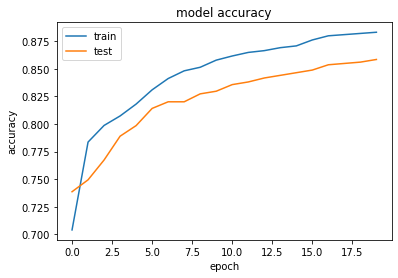

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



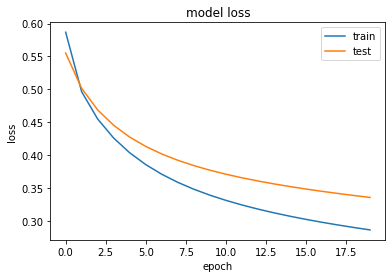

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 142s 153ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



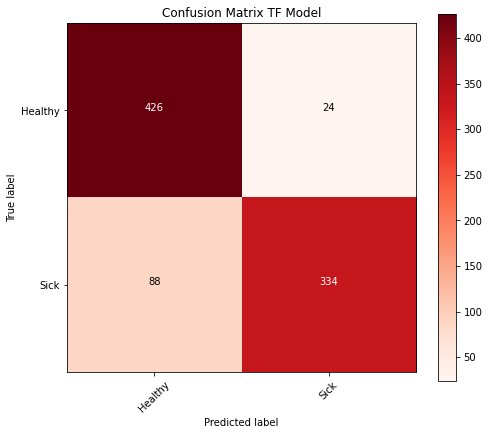

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('cm_wo_norm.png')
plt.show()



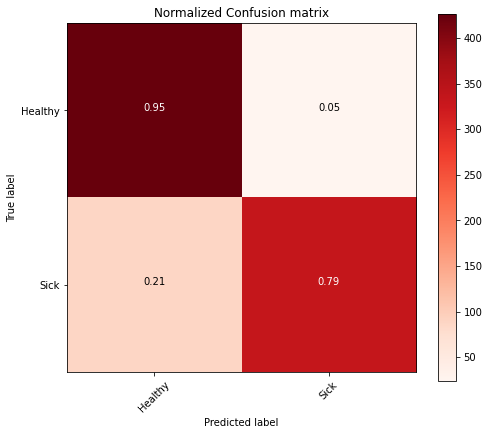

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('cm_norm.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.83      0.95      0.88       450
        Sick       0.93      0.79      0.86       422

    accuracy                           0.87       872
   macro avg       0.88      0.87      0.87       872
weighted avg       0.88      0.87      0.87       872



# Fine-Tuning

In [ ]:
filepath = "/content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L_finetune.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
base_model.trainable = True
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
117/117 [==============================] - 165s 1s/step - loss: 0.3485 - binary_accuracy: 0.8498 - val_loss: 0.5051 - val_binary_accuracy: 0.7566 - lr: 1.0000e-04
Epoch 2/20
117/117 [==============================] - 124s 1s/step - loss: 0.2711 - binary_accuracy: 0.8751 - val_loss: 0.2820 - val_binary_accuracy: 0.9161 - lr: 1.0000e-04
Epoch 3/20
117/117 [==============================] - 124s 1s/step - loss: 0.2001 - binary_accuracy: 0.9133 - val_loss: 0.2052 - val_binary_accuracy: 0.9257 - lr: 1.0000e-04
Epoch 4/20
117/117 [==============================] - 124s 1s/step - loss: 0.1303 - binary_accuracy: 0.9510 - val_loss: 0.1419 - val_binary_accuracy: 0.9448 - lr: 1.0000e-04
Epoch 5/20
117/117 [==============================] - 108s 924ms/step - loss: 0.0984 - binary_accuracy: 0.9645 - val_loss: 0.1628 - val_binary_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 6/20
117/117 [==============================] - 126s 1s/step - loss: 0.0591 - binary_accuracy: 0.9795 - val_loss: 0.1677 

In [ ]:
export_dir='/content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L_save_model_finetuned/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thermal Map Image Dataset/Models/EfficientNetV2L/EfficientNetV2L_save_model_finetuned/assets


In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 55s 52ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

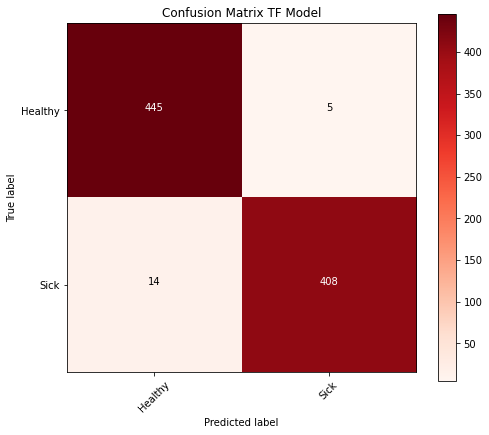

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('cm_wo_norm.png')
plt.show()



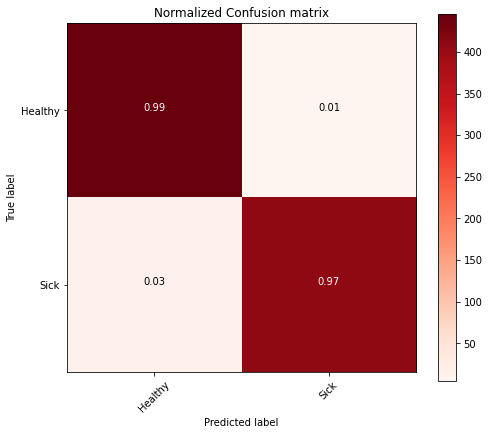

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('cm_norm.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.97      0.99      0.98       450
        Sick       0.99      0.97      0.98       422

    accuracy                           0.98       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.98      0.98       872



In [ ]:
import tensorflow as tf

model_save = tf.keras.models.load_model('/content/drive/MyDrive/Minor Sem 6/Classification with augmentation/EfficientNetB7_withfine_tuning/EfficientNetB7_fine.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
tflite_model = converter.convert()
open("efficientNetb7_fine_tuned.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0h2ajenx/assets


254857188

In [ ]:
add = '/content/drive/MyDrive/Minor Sem 6/Classification with augmentation/EfficientNetB7_withfine_tuning/tflite_model/efficientNetb7_fine_tuned.tflite'
open(add, "wb").write(tflite_model)

254857188

In [ ]:
%ls

cm_norm.jpg     drive/                            sample_data/
cm_wo_norm.png  efficientNetb7_fine_tuned.tflite


In [ ]:
!cp efficientNetb7_fine_tuned.tflite 